# Residuals

In [1]:
strikes <- read.csv('../strikes_clean.csv')

In [265]:
summary(strikes)

      Country         Year          Strike          Unemp       
 Australia: 35   Min.   :1951   Min.   :0.000   Min.   :0.0000  
 Austria  : 35   1st Qu.:1959   1st Qu.:3.135   1st Qu.:0.7885  
 Canada   : 35   Median :1968   Median :4.868   Median :1.2528  
 Denmark  : 35   Mean   :1968   Mean   :4.423   Mean   :1.3018  
 Finland  : 35   3rd Qu.:1977   3rd Qu.:5.894   3rd Qu.:1.8718  
 France   : 35   Max.   :1985   Max.   :8.854   Max.   :2.8904  
 (Other)  :415                                                  
      Infl             Demo           Centr            Dens      
 Min.   :-2.900   Min.   : 8.16   Min.   :0.000   Min.   :15.10  
 1st Qu.: 2.700   1st Qu.:32.20   1st Qu.:0.250   1st Qu.:33.90  
 Median : 4.800   Median :42.50   Median :0.375   Median :43.50  
 Mean   : 5.957   Mean   :40.85   Mean   :0.456   Mean   :45.69  
 3rd Qu.: 8.200   3rd Qu.:49.70   3rd Qu.:0.750   3rd Qu.:57.20  
 Max.   :27.500   Max.   :78.70   Max.   :1.000   Max.   :91.50  
                  

In [2]:
strikes[,'Strike'] <- log(strikes[,'Strike'] + 1)
strikes[,'Unemp'] <- log(strikes[,'Unemp'] + 1)

Hand picked model

In [3]:
M1 <- lm(Strike ~ Country + Unemp + Infl  + Demo + Infl:Dens + Country:Dens - 1, data=strikes)

Backward selected model

In [20]:
M2 <- lm(formula = Strike ~ Country + Year + Unemp + Infl + Dens + 
    I(Unemp^2) + Unemp:Infl + Infl:Dens + Country:Dens - 1, data = strikes)

Plot studentized residuals:

In [42]:
# plotting function from notes
resid_plot <- function(M)
{
res <- resid(M) # usual residuals
H <- model.matrix(M)
H <- H %*% solve(crossprod(H), t(H)) # Hat matrix
h <- diag(H)
res.stu <- resid(M)/sqrt(1-h) # studentized residuals, but on the data scale
cex <- .5 # controls the size of the points and labels
    
# par(mar = c(4,4,.1,.1))
plot(predict(M1), res, cex=cex, xlab = "Log Predicted Strike Activity", ylab = "Studentized Residuals")
}

In [106]:
pdf('plots/studentized_resid.pdf', width=9,height=4) 
# plot side by side
par(mfrow=c(1, 2), oma=c(0,0,2,0))
resid_plot(M1)
title(main='Model 1')
resid_plot(M2)
title(main='Model 2')
mtext('Residuals vs Fitted Values', outer=TRUE)
dev.off()

pdf 
  2

In [100]:
# histogram of studentized residuals
res_hist_plot <- function(M){

# studentized residuals
res <- resid(M)
H <- model.matrix(M)
H <- H %*% solve(crossprod(H), t(H))
h <- diag(H)
res.stu <- resid(M)/sqrt(1-h)
hist(res.stu, breaks = 50, freq = FALSE, cex.axis = cex,
     xlab = "Studentized Residuals", main = "")
curve(dnorm(x), col = "red", add = TRUE) # theoretical normal curve
    }

In [107]:
pdf('plots/resid_hist.pdf', width=9,height=4) 
# plot side by side
par(mfrow=c(1, 2), oma=c(0,0,2,0))
res_hist_plot(M1)
title(main='Model 1')
res_hist_plot(M2)
title(main='Model 2')
mtext('Histogram of Residuals', outer=TRUE)
dev.off()

pdf 
  2

# Influence and Leverage

Leverage vs influence plots reproduced from notes

In [145]:
lev_inf_plot <- function(M){
    # cook’s distance vs. leverage
    D <- cooks.distance(M)
    p <- length(coef(M))
    n <- nobs(M)
    hbar <- p/n # average leverage
    # flag some of the points
    infl.ind <- which.max(D) # top influence point
    lev.ind <- h > 2*hbar # leverage more than 2x the average
    clrs <- rep("black", len = n)
    clrs[lev.ind] <- "blue"
    clrs[infl.ind] <- "red"
    par(mfrow = c(1,1), mar = c(4,4,1,1))
    cex <- .8
    plot(h, D, xlab = "Leverage", ylab = "Cook's Influence Measure", ylim=c(0, 0.08),
         pch = 21, bg = clrs, cex = cex, cex.axis = cex)

    abline(v = 2*hbar, col = "grey60", lty = 2) # 2x average leverage
    legend("topleft", legend = c("High Leverage", "High Influence"), pch = 21,
           pt.bg = c("blue", "red"), cex = cex, pt.cex = cex)
}

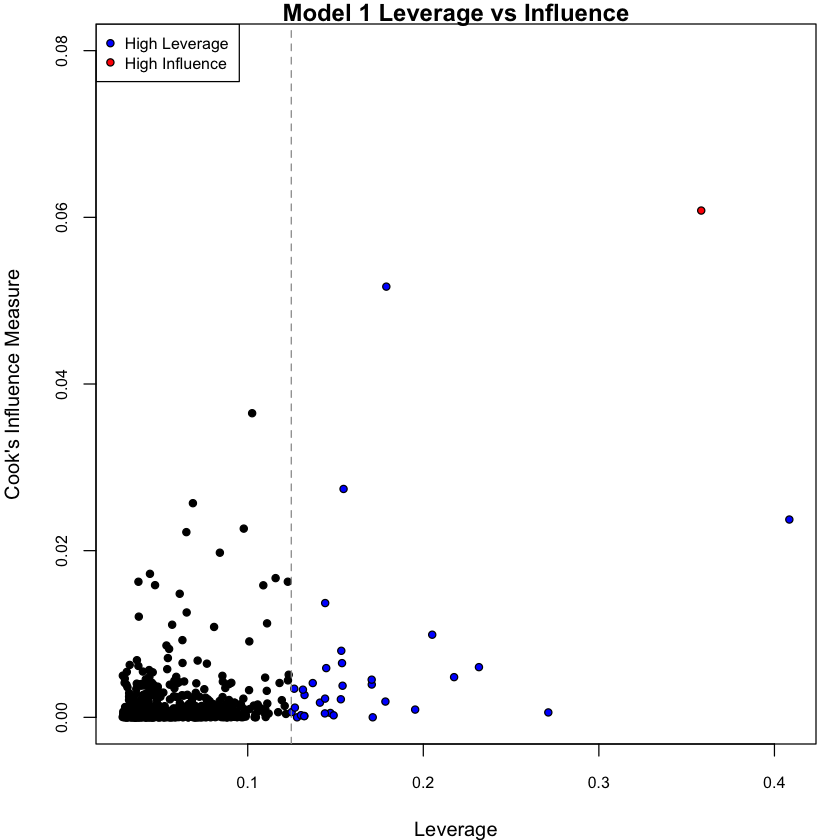

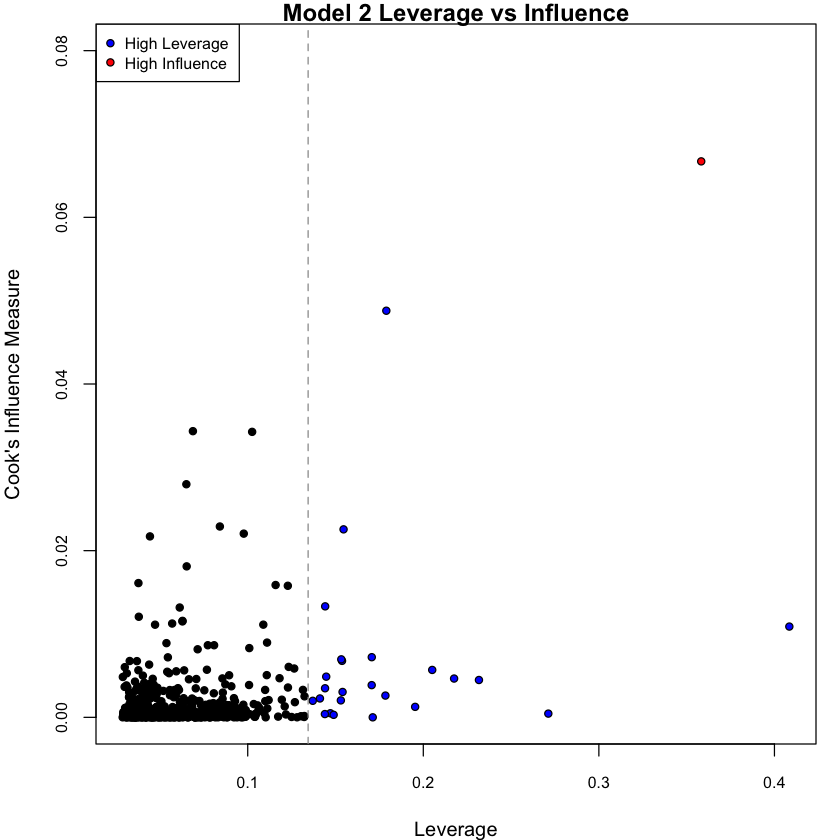

In [237]:
# pdf('plots/m1_inf.pdf', width=4,height=5) 
# plot side by side
lev_inf_plot(M1)
title(main='Model 1 Leverage vs Influence')
# dev.off()

# pdf('plots/m2_inf.pdf', width=4,height=5) 
lev_inf_plot(M2)
title(main='Model 2 Leverage vs Influence')

# dev.off()

Aside: some outliers

In [264]:
D <- cooks.distance(M1) # largest influence
strikes[which.max(D),]

,Country,Year,Strike,Unemp,Infl,Demo,Centr,Dens
346,Japan,1951,6.086775,0.7419373,16.5,17.8,0.125,42.6


In [271]:
strikes[which.max(strikes[,'Strike']),] # largest strike

,Country,Year,Strike,Unemp,Infl,Demo,Centr,Dens
223,France,1968,8.853808,1.280934,4.6,19.1,0,21


# Cross Validation

In [78]:

# Cross-validation
nreps <- 2e3 # number of replications
ntot <- nrow(strikes) # total number of observations
ntrain <- 400 # size of training set
ntest <- ntot-ntrain # size of test set
sse1 <- rep(NA, nreps) # sum-of-square errors for each CV replication
sse2 <- rep(NA, nreps)
Lambda <- rep(NA, nreps) # likelihod ratio statistic for each replication
system.time({
    for(ii in 1:nreps) {
        if(ii%%400 == 0) message("ii = ", ii)
        # randomly select training observations
        train.ind <- sample(ntot, ntrain) # training observations

        # train models
        M1.cv <- update(M1, subset = train.ind)
        M2.cv <- update(M2, subset = train.ind)
        # testing residuals for both models
        M1.res <- strikes$Strike[-train.ind] - predict(M1.cv, newdata = strikes[-train.ind,])
        M2.res <- strikes$Strike[-train.ind] - predict(M2.cv, newdata = strikes[-train.ind,])
        # total sum of square errors
        sse1[ii] <- sum((M1.res)^2)
        sse2[ii] <- sum((M2.res)^2)
        # testing likelihood ratio
        M1.sigma <- sqrt(sum(resid(M1.cv)^2)/ntrain) # MLE of sigma
        M2.sigma <- sqrt(sum(resid(M2.cv)^2)/ntrain)
        Lambda[ii] <- sum(dnorm(M1.res, mean = 0, sd = M1.sigma, log = TRUE))
        Lambda[ii] <- Lambda[ii] - sum(dnorm(M2.res, mean = 0, sd = M2.sigma, log = TRUE))
    }})



ii = 400
ii = 800
ii = 1200
ii = 1600
ii = 2000


   user  system elapsed 
 23.540   0.210  26.169 

Plot the results.

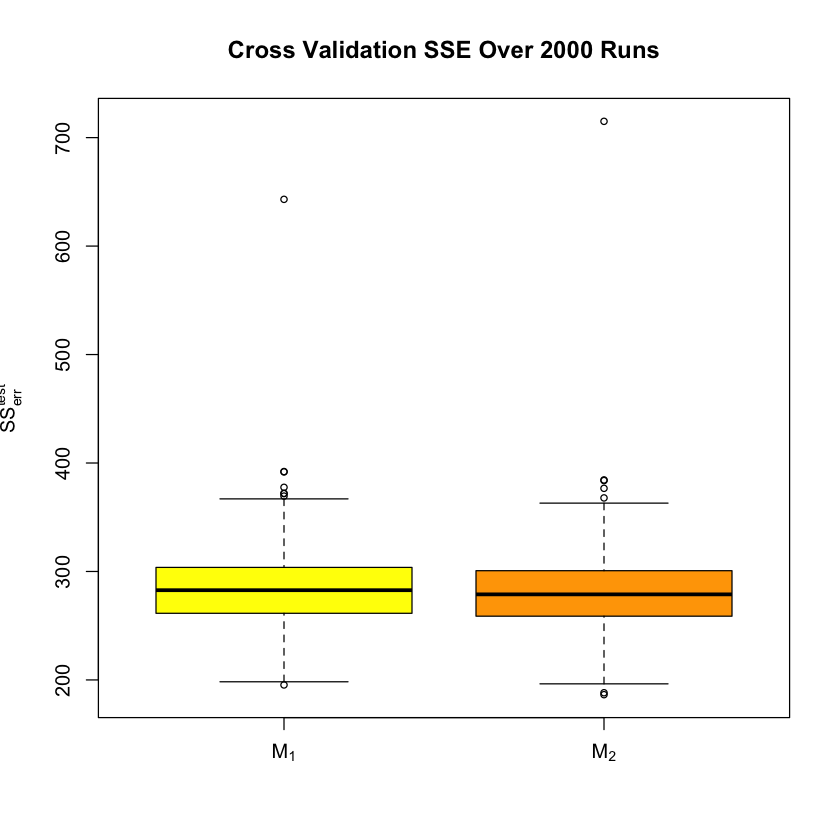

In [172]:
# pdf('plots/cv.pdf', width=7,height=5) 
Mnames <- expression(M[1], M[2])
# plot cross-validation SSE and Lambda
boxplot(x = list(sse1, sse2), names = Mnames, cex = .7,
        ylab = expression(SS[err]^{test}), col = c("yellow", "orange"))
title(main = 'Cross Validation SSE Over 2000 Runs')

# dev.off()

Numeric difference in CV SSE

In [180]:
median(sse2)-median(sse1)

[1] -3.839415

In standard devation of log strike hours:

In [152]:
sd.test <- sqrt(sse1/ntest)-sqrt(sse2/ntest)

In [158]:
summary(sd.test)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-0.092040 -0.001396  0.008419  0.006352  0.015670  0.056020 

Difference in models in terms of standard deviations of log strike hours.

In [168]:
sd.improve <- mean(sd.test)

Residual standard error of M1

In [169]:
rse <- summary(M1)$sigma

Percent improvement in variance:

In [170]:
sd.improve/rse

[1] 0.00598882

# Model selection

We see that the improvement in SSE from Model 2 is very minor, hence we choose the more interpretable Model 1.

In [232]:
# 95% CI
parameters <- confint(M1)
# dataframe including parameter estimates
parameters <- cbind(parameters, coefficients(M1))
colnames(parameters)[3] <- 'Mean'
parameters <- parameters[,c(1,3, 2)]
parameters

,2.5 %,Mean,97.5 %
CountryAustralia,4.342846e+00,5.078039451,5.813233268
CountryAustria,-3.997371e+01,-30.224551217,-20.475394941
CountryBelgium,3.084878e+00,5.731383826,8.377889166
CountryCanada,-1.115117e+00,2.789142504,6.693402220
CountryDenmark,-3.733027e+00,-0.925130356,1.882766470
CountryFinland,3.339402e+00,4.522433771,5.705465873
CountryFrance,-7.174752e-01,2.248135559,5.213746320
CountryGermany,-4.520530e+00,8.199821288,20.920172576
CountryIreland,6.644559e-01,4.060561025,7.456666109
CountryItaly,5.689307e+00,7.601919078,9.514531554


In [235]:
summary(M1)


Call:
lm(formula = Strike ~ Country + Unemp + Infl + Demo + Infl:Dens + 
    Country:Dens - 1, data = strikes)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.8764 -0.6241 -0.0814  0.5275  4.1841 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
CountryAustralia           5.078e+00  3.743e-01  13.566  < 2e-16 ***
CountryAustria            -3.022e+01  4.964e+00  -6.089 2.06e-09 ***
CountryBelgium             5.731e+00  1.347e+00   4.253 2.45e-05 ***
CountryCanada              2.789e+00  1.988e+00   1.403  0.16113    
CountryDenmark            -9.251e-01  1.430e+00  -0.647  0.51782    
CountryFinland             4.522e+00  6.024e-01   7.508 2.25e-13 ***
CountryFrance              2.248e+00  1.510e+00   1.489  0.13706    
CountryGermany             8.200e+00  6.477e+00   1.266  0.20600    
CountryIreland             4.061e+00  1.729e+00   2.348  0.01919 *  
CountryItaly               7.602e+00  9.738e-01   7.806 2.72e-14 ***
CountryJapan        